## Imports and data load

In [1]:
%matplotlib inline
#%matplotlib qt

import matplotlib.pyplot as pyplot
import utils 
import Wear
import numpy as np
import glob
from scipy.interpolate import interp1d    
from copy import deepcopy
import statistics as stats
import math

fileList = sorted(glob.glob('data/wear/*/wynik*.TXT'))
sampleList = [utils.read_wear_data(file) for file in fileList]

## Read and display moving maximum data as a function of sample number

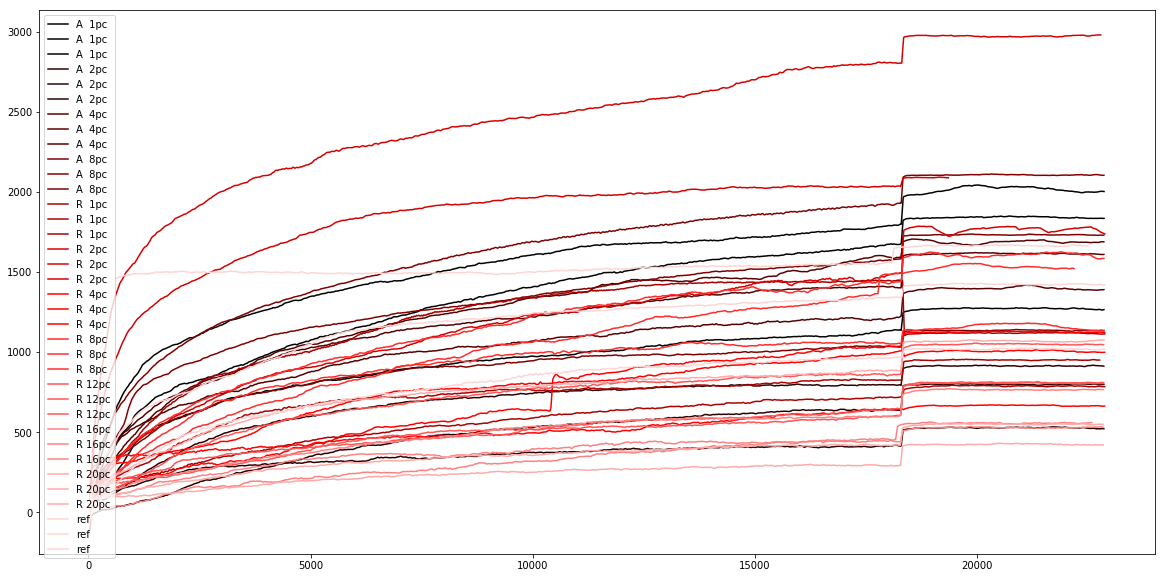

In [2]:
fig = pyplot.figure(figsize=(20,10))
ax = fig.add_subplot(111)

nameList = []
for idx,name in enumerate(fileList):
    newName = name[0:name.rfind("/")]
    newName = newName[newName.rfind("/")+1:]
    nameList.append(newName)
    
for sample in sampleList:
    for idx,wear in enumerate(sample):
        wear.correct_drift(18500, len(wear.depth))

    

utils.plot_wear_samples(ax, sampleList, nameList=nameList, xaxis="sample", color=0)  
#pyplot.xscale('log')
#pyplot.yscale('log')



## Display turncated moving max from depth data

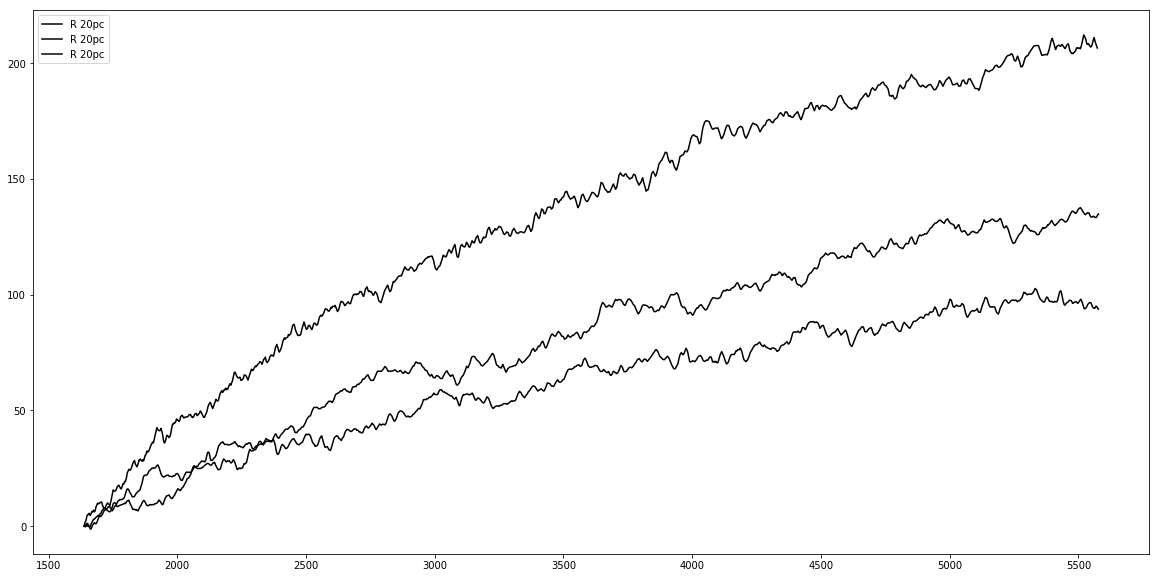

In [16]:
fig2 = pyplot.figure(figsize=(20,10))
ax2 = fig2.add_subplot(111)

sampleListTrunc = deepcopy(sampleList)

for sample in sampleListTrunc:
    for idx,wear in enumerate(sample):
        wear.truncate(5000,17000)
        wear.depth_max = wear.depth_max - wear.depth_max[0]
        wear.depth_min = wear.depth_min - wear.depth_min[0]
        
     
#utils.plot_wear_samples(ax2, sampleListTrunc[0:4], nameList=nameList[0:4], color= 0)
sampleListTrunc[11].pop(0)
#sampleListTrunc[5].pop(0) #huge outlier
sampleListTrunc[6].pop(2) #jump in data
#sampleListTrunc[6].pop(1)
# dorobić dla n=9,10
n = 10

utils.plot_wear_samples(ax2, [sampleListTrunc[n]], nameList=[nameList[n]], color= 0.5)
##utils.plot_wear_samples(ax2, sampleListTrunc, nameList=nameList, color= 0.5)

## Make average of 3 wear experiments for every sample.

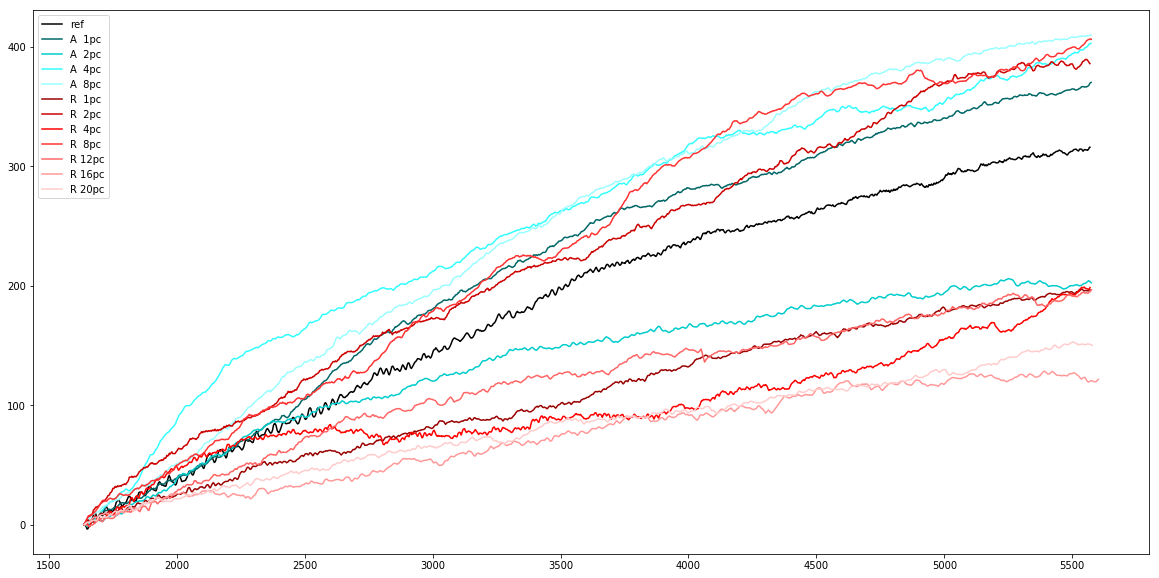

In [4]:
fig3 = pyplot.figure(figsize=(20,10))
ax3 = fig3.add_subplot(111)

sampleMeanList = []

for sample in sampleListTrunc:
    sampleMeanWear = deepcopy(sample[0]) 
    for idx in range(1, len(sample)):
        sampleMeanWear.depth = sampleMeanWear.depth + sample[idx].depth 
        sampleMeanWear.depth_max = sampleMeanWear.depth_max + sample[idx].depth_max
        sampleMeanWear.depth_min = sampleMeanWear.depth_min + sample[idx].depth_min
    sampleMeanWear.depth = sampleMeanWear.depth / len(sample)
    sampleMeanWear.depth_max = sampleMeanWear.depth_max / len(sample)
    sampleMeanWear.depth_min = sampleMeanWear.depth_min / len(sample) 
    sampleMeanList.append(sampleMeanWear)             
        
#utils.plot_mean_wear_samples(ax3, sampleMeanList, nameList=nameList, color=0.1)

utils.plot_mean_wear_samples(ax3, 
                             [sampleMeanList[11]]+sampleMeanList[0:4], 
                             nameList = [nameList[11]] + nameList[0:4], 
                             color=0.5)
utils.plot_mean_wear_samples(ax3, sampleMeanList[4:11], nameList=nameList[4:11], color=0, color_offset = 3)

## Steady state wear rate estimation

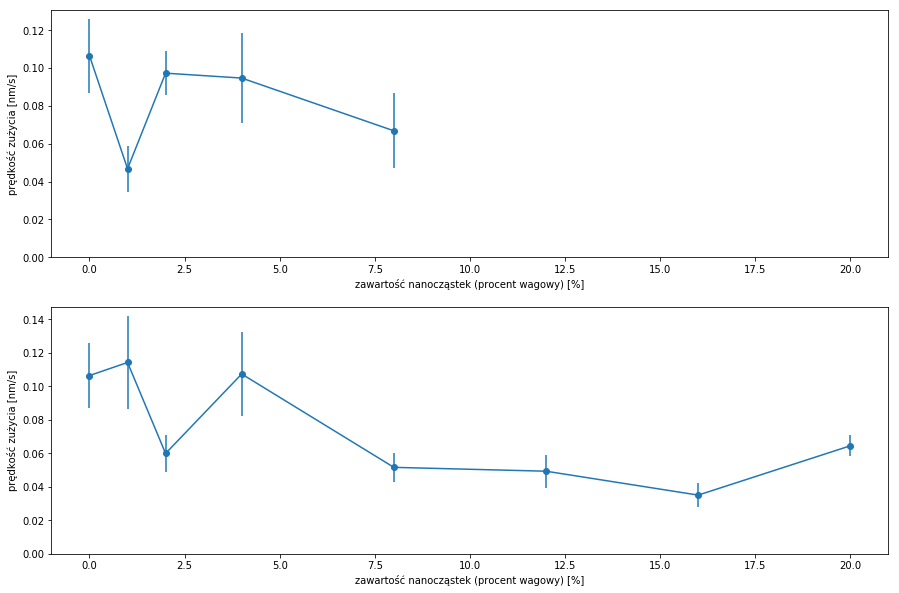

In [5]:
wear_rate_from_max_list = []
wear_rate_from_min_list = []
for sample in sampleListTrunc:
    sample_wear_rate_from_max = []
    sample_wear_rate_form_min = []
    for wear in sample:
        coef_from_max = np.polyfit(wear.time, wear.depth_max, 1)[0]
        coef_from_min = np.polyfit(wear.time, wear.depth_min, 1)[0]
        sample_wear_rate_from_max.append(coef_from_max)
        sample_wear_rate_form_min.append(coef_from_min)
    wear_rate_from_max_list.append(sample_wear_rate_from_max)
    wear_rate_from_min_list.append(sample_wear_rate_form_min)
    
sample_mean_wear_rates_from_max = []
sample_mean_wear_rates_from_min = []
sqr3 = math.sqrt(3)

for idx in range(len(wear_rate_from_max_list)):
    sample_mean_wear_rates_from_max.append( (stats.mean(wear_rate_from_max_list[idx]), stats.stdev(wear_rate_from_max_list[idx])/sqr3 ))
    sample_mean_wear_rates_from_min.append( (stats.mean(wear_rate_from_min_list[idx]), stats.stdev(wear_rate_from_min_list[idx])/sqr3) )
           

fig4 = pyplot.figure(figsize=(15,10))
ax4 = fig4.add_subplot(211)
ax5 = fig4.add_subplot(212)
#x = range(len(sample_mean_wear_rates_from_max))
y = list(map(list, zip (*sample_mean_wear_rates_from_max)))
x = [0, 1, 2, 4, 8, 1, 2, 4, 8, 12, 16, 20]
ax4.errorbar(x[0:5], y[0][0:5], yerr=y[1][0:5], fmt = '-o')
ax5.errorbar([x[0]]+x[5:], [y[0][0]]+y[0][5:], yerr=[y[1][0]]+y[1][5:], fmt = '-o')
ax4.set_ylim(0)
ax4.set_xlabel("zawartość nanocząstek (procent wagowy) [%]")
ax4.set_ylabel("prędkość zużycia [nm/s]")
ax4.set_xlim(-1,21)
ax5.set_ylim(0)
ax5.set_xlabel("zawartość nanocząstek (procent wagowy) [%]")
ax5.set_ylabel("prędkość zużycia [nm/s]")
print('')


        